constants and paths

In [2]:
import os, pickle, numpy as np
from pathlib import Path

RAW_TRAIN_DIR = Path("../data/raw/Cleaned SWANSF Dataset/Cleaned SWANSF Dataset/train/")
RAW_TEST_DIR  = Path("../data/raw/Cleaned SWANSF Dataset/Cleaned SWANSF Dataset/test/")
PARTITIONS_DIR = Path("C:/GitHub/solar-flare-project/data_partitions/")
PARTITIONS_DIR.mkdir(parents=True, exist_ok=True)

NUM_PARTITIONS = 5
NUM_TIMESTEPS = 60
NUM_FEATURES  = 24


** Load data/partitions

In [3]:
import numpy as np
import pickle as pkl
import os

# Load all pickled partitions first
x_train, y_train, x_test, y_test = [], [], [], []

for i in range(NUM_PARTITIONS):
    with open(f"{RAW_TRAIN_DIR}/Partition{i+1}_LSBZM-Norm_FPCKNN-impute.pkl", "rb") as f:
        x_train.append(pkl.load(f))
    with open(f"{RAW_TRAIN_DIR}/Partition{i+1}_Labels_LSBZM-Norm_FPCKNN-impute.pkl", "rb") as f:
        y_train.append(pkl.load(f))

    with open(f"{RAW_TEST_DIR}/Partition{i+1}_RUS-Tomek-TimeGAN_LSBZM-Norm_WithoutC_FPCKNN-impute.pkl", "rb") as f:
        x_test.append(pkl.load(f))
    with open(f"{RAW_TEST_DIR}/Partition{i+1}_Labels_RUS-Tomek-TimeGAN_LSBZM-Norm_WithoutC_FPCKNN-impute.pkl", "rb") as f:
        y_test.append(pkl.load(f))

# Create 25 (5×5) train/test pairs
for i in range(NUM_PARTITIONS):
    for j in range(NUM_PARTITIONS):
        np.savez(
            f"{PARTITIONS_DIR}/train{i+1}_test{j+1}.npz",
            x_train=x_train[i],
            y_train=y_train[i],
            x_test=x_test[j],
            y_test=y_test[j],
        )
        print(f"Saved train{i+1}_test{j+1}.npz")


Saved train1_test1.npz
Saved train1_test2.npz
Saved train1_test3.npz
Saved train1_test4.npz
Saved train1_test5.npz
Saved train2_test1.npz
Saved train2_test2.npz
Saved train2_test3.npz
Saved train2_test4.npz
Saved train2_test5.npz
Saved train3_test1.npz
Saved train3_test2.npz
Saved train3_test3.npz
Saved train3_test4.npz
Saved train3_test5.npz
Saved train4_test1.npz
Saved train4_test2.npz
Saved train4_test3.npz
Saved train4_test4.npz
Saved train4_test5.npz
Saved train5_test1.npz
Saved train5_test2.npz
Saved train5_test3.npz
Saved train5_test4.npz
Saved train5_test5.npz


In [4]:
pair = np.load(PARTITIONS_DIR / "train1_test2.npz")
print("Train:", pair["x_train"].shape, np.bincount(pair["y_train"].astype(int)))
print("Test :", pair["x_test"].shape,  np.bincount(pair["y_test"].astype(int)))


Train: (73492, 60, 24) [72238  1254]
Test : (19807, 60, 24) [10000  9807]


** get partition pair

In [5]:
def get_partition_pair(train_idx, test_idx):
    pair = np.load(PARTITIONS_DIR / f"train{train_idx+1}_test{test_idx+1}.npz")
    Xtr, ytr = pair["x_train"], pair["y_train"]
    Xte, yte = pair["x_test"], pair["y_test"]
    print(f"Loaded train{train_idx+1}_test{test_idx+1}.npz")
    print("Train:", Xtr.shape, np.bincount(ytr.astype(int)))
    print("Test :", Xte.shape, np.bincount(yte.astype(int)))
    return Xtr, ytr, Xte, yte


**Preprocessing for M vs X Classification

build hugging face dataset dir

In [6]:
from datasets import Dataset, DatasetDict

Xtr, ytr, Xte, yte = get_partition_pair(0, 1)

train_ds = Dataset.from_dict({"past_values": Xtr, "labels": ytr})
test_ds  = Dataset.from_dict({"past_values": Xte, "labels": yte})
dataset_dict = DatasetDict({"train": train_ds, "test": test_ds})
dataset_dict


c:\UCCS_Projects\solar-flare-project\.SoFlareEnv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded train1_test2.npz
Train: (73492, 60, 24) [72238  1254]
Test : (19807, 60, 24) [10000  9807]


DatasetDict({
    train: Dataset({
        features: ['past_values', 'labels'],
        num_rows: 73492
    })
    test: Dataset({
        features: ['past_values', 'labels'],
        num_rows: 19807
    })
})

**Convert NumPy arrays to a Hugging Face DatasetDict

In [ ]:
#dataset_dict = build_hf_dataset(Xtr, ytr, Xte, yte)


** Model Configuration and Training

define model with class weights

In [7]:
import torch, torch.nn as nn
from transformers import TimeSeriesTransformerModel

class TimeSeriesTransformerForClassification(nn.Module):
    def __init__(self, config, num_classes=2, class_weights=None):
        super().__init__()
        self.backbone = TimeSeriesTransformerModel(config)
        self.fc = nn.Linear(config.d_model, num_classes)
        self.class_weights = class_weights

    def forward(self, past_values, labels=None):
        B, T, F = past_values.shape
        past_time_features = torch.zeros((B, T, 0), dtype=past_values.dtype, device=past_values.device)
        past_observed_mask = torch.ones((B, T, F), dtype=torch.bool, device=past_values.device)

        out = self.backbone(past_values=past_values,
                            past_time_features=past_time_features,
                            past_observed_mask=past_observed_mask)
        last_hidden = out.last_hidden_state[:, -1, :]
        logits = self.fc(last_hidden)
        loss = None
        if labels is not None:
            if self.class_weights is not None:
                loss_fn = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
            else:
                loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
        return {"loss": loss, "logits": logits}


Collate and metrics

In [8]:
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

def collate_fn(batch):
    X = torch.tensor([b["past_values"] for b in batch], dtype=torch.float32)
    y = torch.tensor([b["labels"] for b in batch], dtype=torch.long)
    return {"past_values": X, "labels": y}

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    TP = np.sum((preds==1)&(labels==1)); TN = np.sum((preds==0)&(labels==0))
    FP = np.sum((preds==1)&(labels==0)); FN = np.sum((preds==0)&(labels==1))
    acc = (TP+TN)/(TP+TN+FP+FN+1e-8)
    recall = TP/(TP+FN+1e-8)
    precision = TP/(TP+FP+1e-8)
    f1 = f1_score(labels, preds)
    tss = recall - (FP/(FP+TN+1e-8))
    hss = (2*(TP*TN-FP*FN))/(((TP+FN)*(FN+TN))+((TP+FP)*(FP+TN))+1e-8)
    return {"accuracy":acc,"precision":precision,"recall":recall,"f1":f1,"tss":tss,"hss":hss}


trainingargs and balanced trainer

In [ ]:
from transformers import TrainingArguments, Trainer
from torch.utils.data import WeightedRandomSampler, DataLoader

labels = np.array(dataset_dict["train"]["labels"])
cls_count = np.array([np.sum(labels==0), np.sum(labels==1)])
weights = 1./cls_count
samples_weight = np.array([weights[int(t)] for t in labels])
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

class BalancedTrainer(Trainer):
    def get_train_dataloader(self):
        return DataLoader(self.train_dataset,
                          batch_size=self.args.train_batch_size,
                          sampler=sampler,
                          collate_fn=self.data_collator,
                          drop_last=True)

training_args = TrainingArguments(
    output_dir="./checkpoints",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=1e-4,
    warmup_ratio=0.1,
    logging_dir="./logs",
    logging_steps=1000,
    save_strategy="no",
)


** Train the Model and Evaluate Metrics

In [11]:
from transformers import TimeSeriesTransformerConfig

config = TimeSeriesTransformerConfig(
    prediction_length=1,
    context_length=NUM_TIMESTEPS,
    input_size=NUM_FEATURES,
    lags_sequence=[0],
    dropout=0.2,
    attention_dropout=0.2,
    num_encoder_layers=4,
    d_model=128,
)

# class weights
w1 = (cls_count[0]/cls_count[1])
class_weights = torch.tensor([1.0, w1*1.5], dtype=torch.float32)
model = TimeSeriesTransformerForClassification(config, class_weights=class_weights)

trainer = BalancedTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["test"],
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

trainer.train()


Step,Training Loss
500,0.382700
1000,0.097500
1500,0.104200
2000,0.046800
2500,0.045800
3000,0.059900
3500,0.042000
4000,0.044000
4500,0.038000
5000,0.033600


TrainOutput(global_step=18372, training_loss=0.056565006599949515, metrics={'train_runtime': 1068.8293, 'train_samples_per_second': 137.519, 'train_steps_per_second': 17.189, 'total_flos': 0.0, 'train_loss': 0.056565006599949515, 'epoch': 2.0})

evaluation and plots

Evaluating model on test set...


c:\UCCS_Projects\solar-flare-project\.SoFlareEnv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Final Evaluation Metrics:
Accuracy:  0.8171
Precision: 0.9809
Recall:    0.6432
F1 Score:  0.7769
TSS:       0.6309


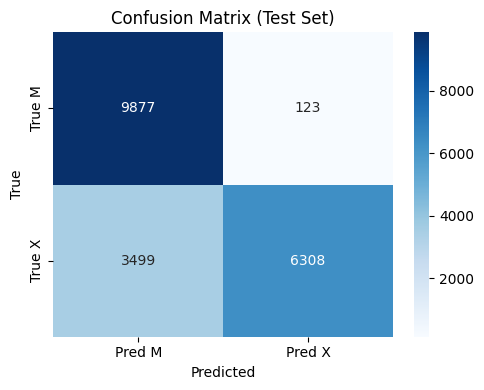

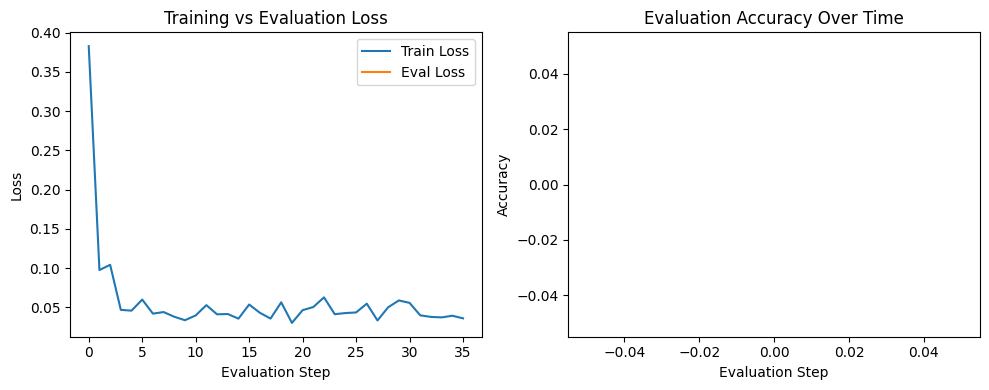

In [14]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)
import torch

# Run model evaluation
print("Evaluating model on test set...")
predictions = trainer.predict(dataset_dict["test"])

# Extract logits and labels
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# ---- Compute metrics ----
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall    = recall_score(y_true, y_pred, zero_division=0)
f1        = f1_score(y_true, y_pred, zero_division=0)

# Compute TSS
cm = confusion_matrix(y_true, y_pred)
if cm.shape == (2, 2):  # Ensure binary case
    tn, fp, fn, tp = cm.ravel()
    tss = (tp / (tp + fn + 1e-9)) - (fp / (fp + tn + 1e-9))
else:
    tss = np.nan

print(f"\nFinal Evaluation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"TSS:       {tss:.4f}")

# ---- Confusion Matrix ----
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred M", "Pred X"],
            yticklabels=["True M", "True X"])
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ---- Training Curves ----
log_history = trainer.state.log_history

# Extract metrics across steps
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_loss  = [x["eval_loss"] for x in log_history if "eval_loss" in x]
eval_acc   = [x["eval_accuracy"] for x in log_history if "eval_accuracy" in x]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss,  label="Eval Loss")
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Evaluation Loss")

plt.subplot(1,2,2)
plt.plot(eval_acc, color="green")
plt.xlabel("Evaluation Step")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy Over Time")
plt.tight_layout()
plt.show()
